In [2]:
#Final project cell 1
#image classification 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm

print("Libraries imported successfully.")

Libraries imported successfully.


In [16]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 30  # You can increase this to 40-50 for slightly better results
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4  # L2 regularization to help prevent overfitting
DROPOUT_RATE = 0.4   # Dropout to help prevent overfitting

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For saving the best model
BEST_MODEL_PATH = "D:/deep learning final project/archive(another)/cifar-10-python.tar.gz"

Using device: cuda


In [18]:
# Define transformations
# These are standard mean and std for CIFAR-10
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

# 1. Transform for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # Adds padding and randomly crops
    transforms.RandomHorizontalFlip(),         # Randomly flips images
    transforms.ToTensor(),                     # Converts to a PyTorch tensor
    transforms.Normalize(cifar10_mean, cifar10_std) # Normalizes the data
])

# 2. Transform for test data (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# 3. Download and create datasets
train_dataset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform
)

# 4. Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

# 5. Define class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")

100%|██████████| 170M/170M [01:29<00:00, 1.90MB/s] 


Training images: 50000
Test images: 10000


In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.4):
        super(SimpleCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2) # 32x32 -> 16x16
        
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2) # 16x16 -> 8x8
        
        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2) # 8x8 -> 4x4
        
        # Classifier
        # Input features: 256 channels * 4 * 4 = 4096
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        
        # Classifier
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

print("Model definition complete.")

Model definition complete.


In [24]:
# 4. Define Learning Rate Scheduler
# This reduces the learning rate when validation loss plateaus
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Monitors validation loss
    factor=0.1,      # Reduces LR by a factor of 10
    patience=3,      # Waits 3 epochs with no improvement
    # Remove the 'verbose=True' argument which caused the error.
)

In [26]:
# To store training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print("Starting training...")

for epoch in range(EPOCHS):
    
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Using tqdm for a progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()
        
        # Update pbar
        train_pbar.set_postfix(loss=running_loss/len(train_pbar), acc=100.*correct_train/total_train)

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct_train / total_train
    
    # --- Validation ---
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    val_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch")
    
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
            
            val_pbar.set_postfix(loss=running_loss/len(val_pbar), acc=100.*correct_val/total_val)

    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct_val / total_val
    
    # --- Epoch Summary ---
    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc:.2f}%")

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Update LR scheduler
    scheduler.step(val_loss)
    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"  [New Best Model Saved to {BEST_MODEL_PATH} with {val_acc:.2f}% acc]")

print("\n--- Training Finished ---")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

Starting training...


Epoch 1/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 1/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 1/30 Summary:
  Train Loss: 1.6515 | Train Acc: 37.18%
  Valid Loss: 1.4173 | Valid Acc: 48.86%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 48.86% acc]


Epoch 2/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 2/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 2/30 Summary:
  Train Loss: 1.1893 | Train Acc: 57.34%
  Valid Loss: 1.2179 | Valid Acc: 59.24%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 59.24% acc]


Epoch 3/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 3/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 3/30 Summary:
  Train Loss: 0.9855 | Train Acc: 65.41%
  Valid Loss: 0.9797 | Valid Acc: 65.93%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 65.93% acc]


Epoch 4/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 4/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 4/30 Summary:
  Train Loss: 0.8611 | Train Acc: 70.06%
  Valid Loss: 0.9596 | Valid Acc: 67.03%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 67.03% acc]


Epoch 5/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 5/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 5/30 Summary:
  Train Loss: 0.7658 | Train Acc: 74.05%
  Valid Loss: 0.7847 | Valid Acc: 72.67%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 72.67% acc]


Epoch 6/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 6/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 6/30 Summary:
  Train Loss: 0.7009 | Train Acc: 76.31%
  Valid Loss: 0.6959 | Valid Acc: 76.46%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 76.46% acc]


Epoch 7/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 7/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 7/30 Summary:
  Train Loss: 0.6388 | Train Acc: 78.47%
  Valid Loss: 0.6425 | Valid Acc: 78.13%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 78.13% acc]


Epoch 8/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 8/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 8/30 Summary:
  Train Loss: 0.5960 | Train Acc: 80.20%
  Valid Loss: 0.6206 | Valid Acc: 79.28%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 79.28% acc]


Epoch 9/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 9/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 9/30 Summary:
  Train Loss: 0.5485 | Train Acc: 81.93%
  Valid Loss: 0.5717 | Valid Acc: 81.11%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 81.11% acc]


Epoch 10/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 10/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 10/30 Summary:
  Train Loss: 0.5144 | Train Acc: 83.03%
  Valid Loss: 0.5613 | Valid Acc: 81.20%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 81.20% acc]


Epoch 11/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 11/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 11/30 Summary:
  Train Loss: 0.4802 | Train Acc: 84.16%
  Valid Loss: 0.4785 | Valid Acc: 83.31%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 83.31% acc]


Epoch 12/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 12/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 12/30 Summary:
  Train Loss: 0.4520 | Train Acc: 85.11%
  Valid Loss: 0.5213 | Valid Acc: 81.98%


Epoch 13/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 13/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 13/30 Summary:
  Train Loss: 0.4282 | Train Acc: 85.93%
  Valid Loss: 0.4886 | Valid Acc: 82.97%


Epoch 14/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 14/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 14/30 Summary:
  Train Loss: 0.4040 | Train Acc: 86.86%
  Valid Loss: 0.4833 | Valid Acc: 83.87%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 83.87% acc]


Epoch 15/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 15/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 15/30 Summary:
  Train Loss: 0.3874 | Train Acc: 87.21%
  Valid Loss: 0.5493 | Valid Acc: 81.69%


Epoch 16/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 16/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 16/30 Summary:
  Train Loss: 0.2752 | Train Acc: 90.83%
  Valid Loss: 0.3317 | Valid Acc: 89.04%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 89.04% acc]


Epoch 17/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 17/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 17/30 Summary:
  Train Loss: 0.2422 | Train Acc: 91.94%
  Valid Loss: 0.3279 | Valid Acc: 89.16%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 89.16% acc]


Epoch 18/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 18/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 18/30 Summary:
  Train Loss: 0.2311 | Train Acc: 92.36%
  Valid Loss: 0.3221 | Valid Acc: 89.43%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 89.43% acc]


Epoch 19/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 19/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 19/30 Summary:
  Train Loss: 0.2161 | Train Acc: 92.72%
  Valid Loss: 0.3179 | Valid Acc: 89.70%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 89.70% acc]


Epoch 20/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 20/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 20/30 Summary:
  Train Loss: 0.2098 | Train Acc: 93.02%
  Valid Loss: 0.3142 | Valid Acc: 89.80%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 89.80% acc]


Epoch 21/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 21/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 21/30 Summary:
  Train Loss: 0.1998 | Train Acc: 93.31%
  Valid Loss: 0.3157 | Valid Acc: 89.92%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 89.92% acc]


Epoch 22/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 22/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 22/30 Summary:
  Train Loss: 0.1891 | Train Acc: 93.68%
  Valid Loss: 0.3147 | Valid Acc: 90.06%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 90.06% acc]


Epoch 23/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 23/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 23/30 Summary:
  Train Loss: 0.1824 | Train Acc: 93.86%
  Valid Loss: 0.3181 | Valid Acc: 89.89%


Epoch 24/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 24/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 24/30 Summary:
  Train Loss: 0.1783 | Train Acc: 94.05%
  Valid Loss: 0.3052 | Valid Acc: 90.06%


Epoch 25/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 25/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 25/30 Summary:
  Train Loss: 0.1703 | Train Acc: 94.30%
  Valid Loss: 0.3166 | Valid Acc: 90.06%


Epoch 26/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 26/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 26/30 Summary:
  Train Loss: 0.1630 | Train Acc: 94.54%
  Valid Loss: 0.3336 | Valid Acc: 89.77%


Epoch 27/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 27/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 27/30 Summary:
  Train Loss: 0.1558 | Train Acc: 94.76%
  Valid Loss: 0.3212 | Valid Acc: 90.31%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 90.31% acc]


Epoch 28/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 28/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 28/30 Summary:
  Train Loss: 0.1513 | Train Acc: 94.87%
  Valid Loss: 0.3294 | Valid Acc: 90.00%


Epoch 29/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 29/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 29/30 Summary:
  Train Loss: 0.1393 | Train Acc: 95.29%
  Valid Loss: 0.3224 | Valid Acc: 90.41%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 90.41% acc]


Epoch 30/30 [Train]:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 30/30 [Val]:   0%|          | 0/79 [00:00<?, ?batch/s]


Epoch 30/30 Summary:
  Train Loss: 0.1354 | Train Acc: 95.43%
  Valid Loss: 0.3235 | Valid Acc: 90.47%
  [New Best Model Saved to D:/deep learning final project/archive(another)/cifar-10-python.tar.gz with 90.47% acc]

--- Training Finished ---
Best Validation Accuracy: 90.47%


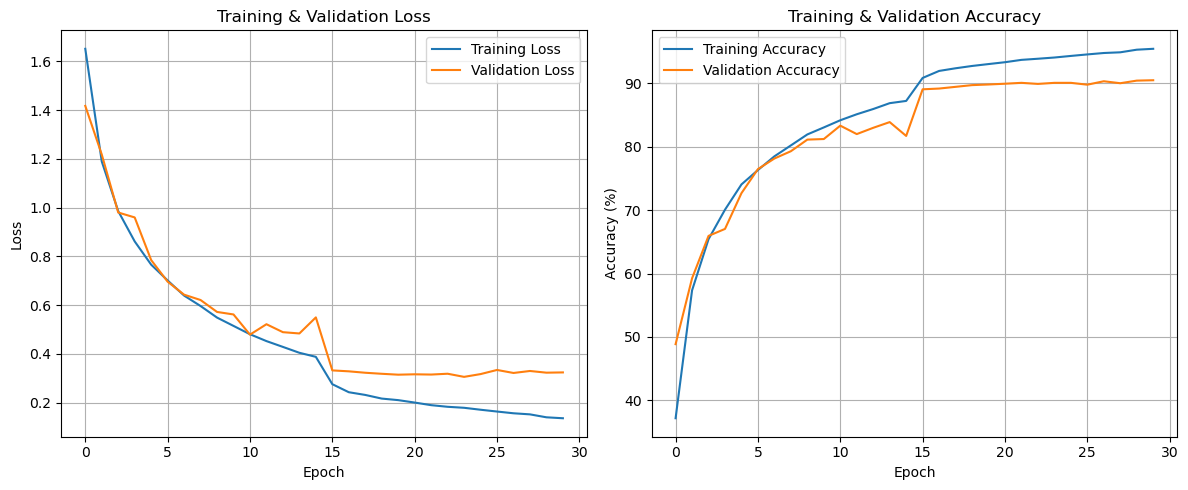

In [28]:
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Final accuracy of the network on the 10000 test images: 90.47 %


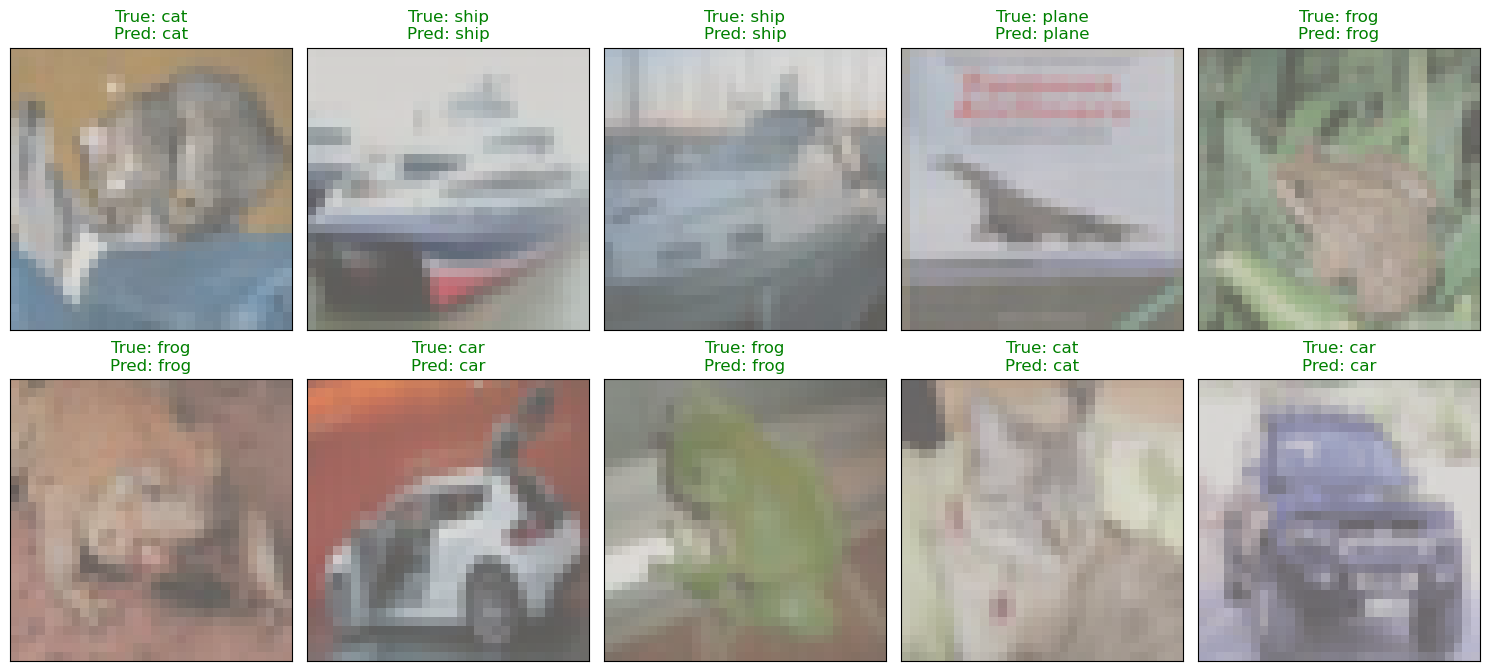

In [30]:
# 1. Load the best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

# 2. Calculate final accuracy on the test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nFinal accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')


# 3. Visualize some predictions (Success & Failure cases)

# Function to un-normalize and show an image
def imshow(img):
    img = img.cpu().numpy() # move to CPU, convert to numpy
    img = img / 2 + 0.5     # unnormalize (this is a simple approximation)
    img = np.transpose(img, (1, 2, 0)) # [C, H, W] -> [H, W, C]
    img = img * cifar10_std + cifar10_mean # un-normalize with true std/mean
    img = np.clip(img, 0, 1) # clip values to [0, 1]
    plt.imshow(img)

# Get one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot the images
fig = plt.figure(figsize=(15, 7))
for idx in np.arange(10): # Show 10 images
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    
    true_label = classes[labels[idx]]
    pred_label = classes[predicted[idx]]
    
    # Set title color
    color = "green" if true_label == pred_label else "red"
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()